In [1]:
using LinearAlgebra
using Unitful
using UnitfulAstro
using OrdinaryDiffEq
using Plots
#using FLoops
#using Distributed
#using DisplayAs
#include("./GalaxyCollisionFunctions.jl")
#addprocs(4)
theme(:dracula)

In [35]:
const G = 4.3009E-3 *1u"pc *(km/s)^2 /Msun"
function format_parameters(galaxy_args)
    #I didn't have this at first, but this makes all galaxies have an uniform format. Not too crazy
    return Dict(
        "mass" => galaxy_args[1]*1u"Msun",
        "radius"     => galaxy_args[2]*1u"kpc",
        "center_pos" => galaxy_args[3].*1u"kpc",
        "center_vel" => galaxy_args[4].*1u"km/s",
        "normal"     => galaxy_args[5],
        "Nᵣ"    => galaxy_args[6],
        "Nₛ"    => galaxy_args[7],
        "softening"  => galaxy_args[8]
    )
end
function init_disk!(galaxy,dT=1E-4u"yr")
    #=
    This function takes a 'galaxy' as an argument, which is an array of 8 arguments=>
        [mass,radius,center_pos,center_vel,normal,N_rings,N_stars,softening]
    And outputs the star positions, velocities and the velocity scale.
    =#
    dr = (1-galaxy["softening"]) * galaxy["radius"]/galaxy["Nᵣ"] # Disregarding the softening, this is just the width of the rings(raidus/number of slices)
    StarsPerRing = trunc(Int64,galaxy["Nₛ"]/galaxy["Nᵣ"])
#-------------------------------------------------------------Rotations--------------------------------------------------------------
    if norm(galaxy["normal"]) == 0 
        Rotation = I
    else 
        cosθ = normalize(galaxy["normal"])[3]
        sinθ = √(1-cosθ^2)
        u = [0,0,1] × normalize(galaxy["normal"])
        if norm(u) == 0 
            Rotation = I
        else 
         u = normalize(u)

        Rotation = [
            u[1]*u[1]*(1-cosθ)+cosθ u[1]*u[2]*(1-cosθ)-u[2]*sinθ u[1]*u[3]*(1-cosθ)+u[1]*sinθ;

            u[2]*u[1]*(1-cosθ)+u[3]*sinθ u[2]*u[2]*(1-cosθ)+cosθ u[2]*u[3]*(1-cosθ)-u[1]*sinθ;

            u[3]*u[1]*(1-cosθ)+u[2]*sinθ u[3]*u[1]*(1-cosθ)+u[1]*sinθ u[3]*u[3]*(1-cosθ)+cosθ
            ]
        end
    end
#-----------------------------------------------------------------------------------------------------------------------------------
    galaxy["star_pos"] = []
    galaxy["star_vel"] = []

    R = galaxy["softening"] * galaxy["radius"]
    for i ∈ 1:galaxy["Nᵣ"] #iterate over the rings
        #Randomly distribute the initial radii and angles 
        rₛ =(R * ones(StarsPerRing) + dr *rand(StarsPerRing))./1u"kpc" #creates an n-dimensional vector of radii from R to R+dr 
        ϕₛ = 2π *rand(StarsPerRing)

        # Positions 
        vecᵣ = (Rotation * ([rₛ.*cos.(ϕₛ),rₛ.*sin.(ϕₛ),zeros(StarsPerRing)])).*1u"kpc"
        x = ustrip.(u"m",galaxy["center_pos"][1].+vecᵣ[1])#here, we strip our units into our 'integrating' unitlessness because units don't really play nice in arrays of arrays
        y = ustrip.(u"m",galaxy["center_pos"][2].+vecᵣ[2])
        z = ustrip.(u"m",galaxy["center_pos"][3].+vecᵣ[3])

        # Velocities
        Tₛ = 2π * uconvert.(u"s",sqrt.((rₛ*1u"kpc").^3/(G *galaxy["mass"])))

        Δϕ = 2π *uconvert(u"s",dT)./Tₛ 

        vecᵥ = (Rotation* [(rₛ/(uconvert(u"s",dT)*1u"1/s")).*(cos.(ϕₛ)-cos.(ϕₛ-Δϕ)),rₛ/(uconvert(u"s",dT)*1u"1/s").*(sin.(ϕₛ)-sin.(ϕₛ-Δϕ)),zeros(StarsPerRing)])*1u"kpc/s"
        v₁ = ustrip.(u"m/s",galaxy["center_vel"][1].+vecᵥ[1])
        v₂ = ustrip.(u"m/s",galaxy["center_vel"][2].+vecᵥ[2])
        v₃ = ustrip.(u"m/s",galaxy["center_vel"][3].+vecᵥ[3])
        for j ∈ 1:StarsPerRing
            push!(galaxy["star_pos"],[x[j],y[j],z[j]])
            push!(galaxy["star_vel"],[v₁[j],v₂[j],v₃[j]])
        end
        R += dr
    end 
    galaxy["vel_scale"]=uconvert(u"km/s",√(G*galaxy["mass"]/(0.5*R)))
end


function evolve_disk(galaxy,dT=1e-4u"yr",N_steps=100000,frames=500)
    divs = trunc(Int64,N_steps/frames)
    #Integration stuff
    dT=ustrip(u"s",dT)
    rₘ=ustrip(u"m",galaxy["softening"]*galaxy["radius"])
    Nₛ=galaxy["Nₛ"]
    
    #Galaxy stuff
    M = ustrip(u"Msun",galaxy["mass"])
    R₀ = ustrip.(u"m",galaxy["center_pos"])
    V₀ = ustrip.(u"m/s",galaxy["center_vel"])

    #star stuff
    rₛ=galaxy["star_pos"]
    vₛ=galaxy["star_vel"]

    function Gravity(dq::Vector{Float64},q::Vector{Float64},m,t::Float64)::Vector{Float64}
        r = q[1:3]
        R = q[4:6]
        ddr = ustrip(u"m^3/s^2",G*M*1u"Msun")*(R-r)/max(norm(R-r),rₘ)^3
        ddR = [0,0,0]
        append!(ddr,ddR)
        return ddr
    end
    Integrator=[]
    for i ∈ 1:Nₛ
        append!(vₛ[i],V₀)
        append!(rₛ[i],R₀)
    end
    for i ∈ 1:Nₛ
        push!(Integrator,init(SecondOrderODEProblem(Gravity,vₛ[i],rₛ[i],(0,dT*N_steps)),dt=dT,SymplecticEuler()))
    end 
    snapshot = zeros(frames,Nₛ+1,3)
    time = zeros(frames)
        for i ∈ 1:frames
            for j ∈ 1:Nₛ
                snapshot[i,j,:] =Integrator[j].u[7:9]*3.240779289444365e-20
            end
            snapshot[i,Nₛ+1,:] = Integrator[1].u[10:12]*3.240779289444365e-20
            time[i]=Integrator[1].t

            for j ∈ 1:divs
                step!.(Integrator)
            end
        end
    return snapshot,time 
end

function gif_galaxy(data,time,Nₛ,xlimit=[0,0],ylimit=[0,0],zlimit=[0,0])
    if ((norm(xlimit) == 0.0) || (norm(ylimit) == 0.0) || (norm(zlimit) == 0.0))
        xlimit = [minimum(data[:,:,1]),maximum(data[:,:,1])]
        ylimit = [minimum(data[:,:,2]),maximum(data[:,:,2])]
        zlimit = [minimum(data[:,:,3]),maximum(data[:,:,3])]
    end
    @gif for i ∈ 1:length(time)
        scatter3d(xlim=xlimit,ylim=ylimit,zlim=zlimit)
        for j ∈ 1:Nₛ
            scatter3d!(data[i:i,j,1],data[i:i,j,2],data[i:i,j,3], color=:red,legends=false,markersize=1.5)
           # i > trail ? plot3d!(Rotated[j][1,1:i],Rotated[j][2,1:i],Rotated[j][3,1:i]) : nothing
        end
        scatter3d!(data[i:i,Nₛ+1,1],data[i:i,Nₛ+1,2],data[i:i,Nₛ+1,3], color=:black,legends=false)
    end 
end

function gif_two_galaxies(data,time,N₁,N₂,xlimit=[0,0],ylimit=[0,0],zlimit=[0,0])
    if ((norm(xlimit) == 0.0) || (norm(ylimit) == 0.0) || (norm(zlimit) == 0.0))
        xlimit = [minimum(data[1:5,:,1]),maximum(data[1:5,:,1])]
        ylimit = [minimum(data[1:5,:,2]),maximum(data[1:5,:,2])]
        zlimit = [minimum(data[1:5,:,3]),maximum(data[1:40,:,3])]
    end
    @gif for i ∈ 1:length(time)
        scatter3d(xlim=xlimit,ylim=ylimit,zlim=zlimit)
        for j ∈ 1:N₁
            scatter3d!(data[i:i,j,1],data[i:i,j,2],data[i:i,j,3], color=:red,legends=false,markersize=1)
        end
        for j ∈ 1:N₂
            scatter3d!(data[i:i,N₁+j,1],data[i:i,N₁+j,2],data[i:i,N₁+j,3], color=:blue,legends=false,markersize=1)
           # i > trail ? plot3d!(Rotated[j][1,1:i],Rotated[j][2,1:i],Rotated[j][3,1:i]) : nothing
        end
        scatter3d!(data[i:i,N₁+N₂+1,1],data[i:i,N₁+N₂+1,2],data[i:i,N₁+N₂+1,3], color=:black,legends=false)
        scatter3d!(data[i:i,N₁+N₂+2,1],data[i:i,N₁+N₂+2,2],data[i:i,N₁+N₂+2,3], color=:black,legends=false)
    end 
end

function evolve_two_disks(primary,secondary,dT=1e-4u"yr",N_steps=100000,frames=500)
    #Integration stuff
    divs = trunc(Int64,N_steps/frames)
    dT=ustrip(u"s",dT)
    r₁ₘ,r₂ₘ=ustrip(u"m",primary["softening"]*primary["radius"]),ustrip(u"m",secondary["softening"]*secondary["radius"])
    N₁ₛ,N₂ₛ=primary["Nₛ"],secondary["Nₛ"]
    
    #Galaxy stuff
    M = [ustrip(u"Msun",primary["mass"]),ustrip(u"Msun",secondary["mass"])]
    R₁,R₂ = ustrip.(u"m",primary["center_pos"]),ustrip.(u"m",secondary["center_pos"])
    V₁,V₂ = ustrip.(u"m/s",primary["center_vel"]),ustrip.(u"m/s",secondary["center_vel"])

    #star stuff
    r₁,r₂=primary["star_pos"],secondary["star_pos"]
    v₁,v₂=primary["star_vel"], secondary["star_vel"]


    function Gravitus(dq::Vector{Float64},q::Vector{Float64},m::Vector{Float64},t::Float64)::Vector{Float64}
        pegnor= q[1:3]
        R₁,R₂= q[4:6],q[7:9]
        ddpegnor = ustrip(u"m^3/s^2",G*m[1]*1u"Msun")*(R₁-pegnor)/max(norm(R₁-pegnor),r₁ₘ)^3+ustrip(u"m^3/s^2",G*m[2]*1u"Msun")*(R₂-pegnor)/max(norm(R₂-pegnor),r₂ₘ)^3
        ddR₁ = ustrip(u"m^3/s^2",G*m[1]*1u"Msun")*(R₂-R₁)/max(norm(R₁-R₂),r₁ₘ)^3
        ddR₂ = -ddR₁
        append!(ddpegnor,ddR₁,ddR₂)
        return ddpegnor
    end
    
    Integrator=[]
    for i ∈ 1:N₁ₛ
        append!(v₁[i],V₁,V₂)
        append!(r₁[i],R₁,R₂)
    end
    for i ∈ 1:N₂ₛ
        append!(v₂[i],V₁,V₂)
        append!(r₂[i],R₁,R₂)
    end
    
    for k ∈ 1:N₁ₛ
        push!(Integrator,init(SecondOrderODEProblem(Gravitus,v₁[k],r₁[k],(0,N_steps*dT),M),dt=dT,SymplecticEuler()))
    end
    
    for i ∈ 1:N₂ₛ
        push!(Integrator,init(SecondOrderODEProblem(Gravitus,v₂[i],r₂[i],(0,N_steps*dT),M),dt=dT,SymplecticEuler()))
    end 
    snapshot = zeros(frames,N₁ₛ+N₂ₛ+2,3)
    time = zeros(frames)
        for i ∈ 1:frames
            for j ∈ 1:N₁ₛ
                snapshot[i,j,:] =Integrator[j].u[10:12]*3.240779289444365e-20
            end
            for j ∈ 1:N₂ₛ
                snapshot[i,N₁ₛ+j,:] =Integrator[N₁ₛ+j].u[10:12]*3.240779289444365e-20
            end
            snapshot[i,N₁ₛ+N₂ₛ+1,:] = Integrator[1].u[13:15]*3.240779289444365e-20
            snapshot[i,N₁ₛ+N₂ₛ+2,:] = Integrator[1].u[16:18]*3.240779289444365e-20
            time[i]=Integrator[1].t * ustrip(u"Myr",1u"s")
            for j ∈ 1:divs
                step!.(Integrator)
            end
        end
    return snapshot,time 
end


evolve_two_disks (generic function with 4 methods)

In [40]:
Target = format_parameters([5e10, 10, [-5,5,1], [15,-15,0], [1,-1,2^0.5], 10, 800, 0.025])
Introoder = format_parameters([1e10,5,[25,-25,-5],[-75,75,0],[0,0,1],5,200,0.025])
init_disk!(Introoder)
init_disk!(Target)
data, time = evolve_two_disks(Introoder,Target,0.5u"Myr",1000,200)
#data,time = evolve_disk(Target,0.05u"Myr",10000,300)

([24.397896682154144 25.393978728340695 … 25.0 -4.999999999999999; 24.16491876067605 25.006017557695632 … 24.80819832588911 -4.961605150645961; … ; 11.277435170444694 -62.12196085839235 … -7.296101402401416 -3.0784498994556966; 11.34814674601543 -62.89784371583958 … -7.373569003514188 -3.1543891230997785;;; -24.720378441165273 -25.132324441908267 … -25.0 4.999999999999999; -25.133722183460144 -24.316943895782526 … -24.80819832588911 4.961605150645961; … ; -32.993618645441195 78.03520926716304 … 7.296101402401416 3.0784498994556966; -33.26587927445362 79.013858657488 … 7.373569003514188 3.1543891230997785;;; -4.999999999999999 -4.999999999999999 … -4.999999999999999 0.9999999999999999; -4.999956913607657 -4.999961567186327 … -4.999991344751332 0.9999913447513323; … ; -43.431839110280265 5.225817491646796 … 13.660765243961059 -17.66076524396105; -43.891933944074786 5.30925212971522 … 13.83011645404294 -17.83011645404293], [0.0, 2.5, 5.0, 7.5, 10.0, 12.5, 15.0, 17.5, 20.0, 22.5  …  475.0,

┌ Info: Saved animation to /tmp/jl_JkZ0HOFoXY.gif
└ @ Plots /home/biel/.julia/packages/Plots/QZRtR/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_JkZ0HOFoXY.gif")
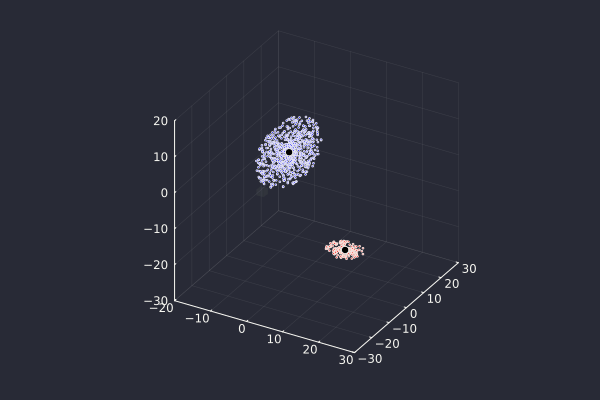

In [42]:

#gif_galaxy(data,time,Target["Nₛ"])
gif_two_galaxies(data,time,Introoder["Nₛ"],Target["Nₛ"],[-20,30],[-30,30],[-30,20])


In [5]:
Target = format_parameters([5e10, 10, [-5,5,1], [15,-15,0], [1,-1,2^0.5], 10, 40, 0.025])
Introoder = format_parameters([1e10,5,[25,-25,-5],[-75,75,0],[0,0,1],5,60,0.025])
init_disk!(Introoder)
init_disk!(Target)
r₁ₘ,r₂ₘ=ustrip(u"m",Introoder["softening"]*Introoder["radius"]),ustrip(u"m",Target["softening"]*Target["radius"])
M = [ustrip(u"Msun",Introoder["mass"]),ustrip(u"Msun",Target["mass"])]
r₁ₘ,r₂ₘ=ustrip(u"m",Introoder["softening"]*Introoder["radius"]),ustrip(u"m",Target["softening"]*Target["radius"])
N₁ₛ,N₂ₛ=Introoder["Nₛ"],Target["Nₛ"]
R₁,R₂ = ustrip.(u"m",Introoder["center_pos"]),ustrip.(u"m",Target["center_pos"])
V₁,V₂ = ustrip.(u"m/s",Introoder["center_vel"]),ustrip.(u"m/s",Target["center_vel"])
r₁,r₂=Introoder["star_pos"],Target["star_pos"]
v₁,v₂=Introoder["star_vel"], Target["star_vel"]


function Gravitus(dq::Vector{Float64},q::Vector{Float64},m::Vector{Float64},t::Float64)::Vector{Float64}
        r₁= q[1:3]
        R₁,R₂= q[4:6],q[7:9]
        ddr₁ = ustrip(u"m^3/s^2",G*m[1]*1u"Msun")*(R₁-r₁)/max(norm(R₁-r₁),r₁ₘ)^3+ustrip(u"m^3/s^2",G*m[2]*1u"Msun")*(R₂-r₁)/max(norm(R₂-r₁),r₂ₘ)^3
        ddR₁ = ustrip(u"m^3/s^2",G*m[1]*1u"Msun")*(R₂-R₁)/max(norm(R₁-R₂),r₁ₘ,r₂ₘ)^3
        ddR₂ = -ddR₁
        append!(ddr₁,ddR₁,ddR₂)
        return ddr₁
end


Integrator=[]
for i ∈ 1:N₁ₛ
    append!(v₁[i],V₁,V₂)
    append!(r₁[i],R₁,R₂)
end
for i ∈ 1:N₂ₛ
    append!(v₂[i],V₁,V₂)
    append!(r₂[i],R₁,R₂)
end
for k ∈ 1:N₁ₛ
    push!(Integrator,init(SecondOrderODEProblem(Gravitus,v₁[k],r₁[k],(0,100.123),M),dt=1,IRKN4()))
end

for i ∈ 1:N₂ₛ
    push!(Integrator,init(SecondOrderODEProblem(Gravitus,v₂[i],r₂[i],(0,100.123),M),dt=0.1,SymplecticEuler()))
end 
for i ∈ 1:100
    step!.(Integrator)
end

LoadError: MethodError: no method matching perform_step!(::OrdinaryDiffEq.ODEIntegrator{IRKN4, false, RecursiveArrayTools.ArrayPartition{Float64, Tuple{Vector{Float64}, Vector{Float64}}}, Nothing, Float64, Vector{Float64}, Float64, Float64, Float64, Float64, Vector{RecursiveArrayTools.ArrayPartition{Float64, Tuple{Vector{Float64}, Vector{Float64}}}}, ODESolution{Float64, 2, Vector{RecursiveArrayTools.ArrayPartition{Float64, Tuple{Vector{Float64}, Vector{Float64}}}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{RecursiveArrayTools.ArrayPartition{Float64, Tuple{Vector{Float64}, Vector{Float64}}}}}, ODEProblem{RecursiveArrayTools.ArrayPartition{Float64, Tuple{Vector{Float64}, Vector{Float64}}}, Tuple{Float64, Float64}, false, Vector{Float64}, DynamicalODEFunction{false, SciMLBase.FullSpecialize, ODEFunction{false, SciMLBase.FullSpecialize, typeof(Gravitus), UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, ODEFunction{false, SciMLBase.FullSpecialize, SciMLBase.var"#276#278", UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SecondOrderODEProblem{false}}, IRKN4, OrdinaryDiffEq.InterpolationData{DynamicalODEFunction{false, SciMLBase.FullSpecialize, ODEFunction{false, SciMLBase.FullSpecialize, typeof(Gravitus), UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, ODEFunction{false, SciMLBase.FullSpecialize, SciMLBase.var"#276#278", UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Vector{RecursiveArrayTools.ArrayPartition{Float64, Tuple{Vector{Float64}, Vector{Float64}}}}, Vector{Float64}, Vector{Vector{RecursiveArrayTools.ArrayPartition{Float64, Tuple{Vector{Float64}, Vector{Float64}}}}}, OrdinaryDiffEq.IRKN4ConstantCache{Float64, Float64}}, DiffEqBase.DEStats, Nothing}, DynamicalODEFunction{false, SciMLBase.FullSpecialize, ODEFunction{false, SciMLBase.FullSpecialize, typeof(Gravitus), UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, ODEFunction{false, SciMLBase.FullSpecialize, SciMLBase.var"#276#278", UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, OrdinaryDiffEq.IRKN4ConstantCache{Float64, Float64}, OrdinaryDiffEq.DEOptions{Float64, Float64, Float64, Float64, PIController{Int64}, typeof(DiffEqBase.ODE_DEFAULT_NORM), typeof(opnorm), Nothing, CallbackSet{Tuple{}, Tuple{}}, typeof(DiffEqBase.ODE_DEFAULT_ISOUTOFDOMAIN), typeof(DiffEqBase.ODE_DEFAULT_PROG_MESSAGE), typeof(DiffEqBase.ODE_DEFAULT_UNSTABLE_CHECK), DataStructures.BinaryHeap{Float64, DataStructures.FasterForward}, DataStructures.BinaryHeap{Float64, DataStructures.FasterForward}, Nothing, Nothing, Int64, Tuple{}, Tuple{}, Tuple{}}, RecursiveArrayTools.ArrayPartition{Float64, Tuple{Vector{Float64}, Vector{Float64}}}, Float64, Nothing, OrdinaryDiffEq.DefaultInit}, ::OrdinaryDiffEq.IRKN4ConstantCache{Float64, Float64})
[0mClosest candidates are:
[0m  perform_step!(::Any, [91m::Union{OrdinaryDiffEq.HeunCache, OrdinaryDiffEq.RalstonCache}[39m) at C:\Users\batti\.julia\packages\OrdinaryDiffEq\P7HJO\src\perform_step\fixed_timestep_perform_step.jl:155
[0m  perform_step!(::Any, [91m::Union{OrdinaryDiffEq.HeunCache, OrdinaryDiffEq.RalstonCache}[39m, [91m::Any[39m) at C:\Users\batti\.julia\packages\OrdinaryDiffEq\P7HJO\src\perform_step\fixed_timestep_perform_step.jl:155
[0m  perform_step!(::Any, [91m::Union{OrdinaryDiffEq.HeunConstantCache, OrdinaryDiffEq.RalstonConstantCache}[39m) at C:\Users\batti\.julia\packages\OrdinaryDiffEq\P7HJO\src\perform_step\fixed_timestep_perform_step.jl:99
[0m  ...

In [ ]:
cosθ = normalize(Introoder["normal"])
Rotation = rand(3,3)
R = Introoder["softening"] * Introoder["radius"]
dr = (1-Introoder["softening"]) * Introoder["radius"]/Introoder["Nᵣ"] # Disregarding the softening, this is just the width of the rings(raidus/number of slices)
StarsPerRing = trunc(Int64,Introoder["Nₛ"]/Introoder["Nᵣ"])
rₛ = (R * ones(StarsPerRing) + dr *rand(StarsPerRing))./1u"kpc" #creates an n-dimensional vector of radii from R to R+dr 
ϕₛ = 2π *rand(StarsPerRing)
cosθ = normalize(Introoder["normal"])[3]
        sinθ = √(1-cosθ^2)
        u = [0,0,1] × normalize(Introoder["normal"])
        u = normalize(u)

        Rotation = [
        u[1]*u[1]*(1-cosθ)+cosθ u[1]*u[2]*(1-cosθ)-u[2]*sinθ u[1]*u[3]*(1-cosθ)+u[1]*sinθ;

        u[2]*u[1]*(1-cosθ)+u[3]*sinθ u[2]*u[2]*(1-cosθ)+cosθ u[2]*u[3]*(1-cosθ)-u[1]*sinθ;

        u[3]*u[1]*(1-cosθ)+u[2]*sinθ u[3]*u[1]*(1-cosθ)+u[1]*sinθ u[3]*u[3]*(1-cosθ)+cosθ
        ]
        vecᵣ =Rotation.*[rₛ.*cos.(ϕₛ),rₛ.*sin.(ϕₛ),zeros(StarsPerRing)].*1u"pc"
        Introoder["center_pos"][1] .+ vecᵣ[1]
        #Tₛ = 2π *sqrt.(((rₛ*1u"pc")^3)/(G *galaxy["mass"]))
   uconvert.(u"s",sqrt.((rₛ*1u"kpc").^3/(G *Introoder["mass"])))
   dT=1E-4u"yr"
uconvert(u"s",dT)
Introoder["center_pos"][1].+vecᵣ[1]
